**1.Business Problem**

Open-i (Open Access Biomedical Image Search Engine) service of the National Library of Medicine enables search and retrieval of abstracts and images (including charts, graphs, clinical images, etc.) from the open source literature, and biomedical image collections. Searching may be done using text queries as well as query images. Open-i provides access to over 3.7 million images from about 1.2 million PubMed Central® articles; 7,470 chest x-rays with 3,955 radiology reports; 67,517 images from NLM History of Medicine collection; and 2,064 orthopedic illustrations.

**2. DATASET**

This dataset have radiology reports for the corresponding chest x ray images from indiana university.



*   In dataset images are available in png format 
*   In dataset reports are available in xml format.



*   Each xml file have the report for the correspondings chest xray of patients.
*  Important info is that more than one image is associated for one reports.








**3. SOURCE OF DATA**

*   Main data source: https://openi.nlm.nih.gov/
*   I also refer a source of kaggle to project the frontal and lateral image which you see later in eda 

source of data:https://www.kaggle.com/raddar/chest-xrays-indiana-university



**4. Problem statement**

We have to generate the medical reports(impressions) for given chest xrays of patient.

**5. Constraints:**

1.   Interpretability of model or result
2.   no latency requirement.

1.   Model prediction should be highly accurate. because its depend on the judement to save a person life.





**6. Performance metrics**


1.   Bleu score for sentence generation evaluation



**Import all imoprtant models**

In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import xml.etree.ElementTree as ET
import os
import cv2 
import tensorflow as tf
from wordcloud import WordCloud
import re
from collections import defaultdict
import itertools
from collections import Counter
import warnings
warnings.filterwarnings("ignore")



from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.manifold import TSNE
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Mount the Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

**Set the path of the directory**

In [2]:
path='/content/drive/My Drive/ecgen-radiology'

**Retreive all the findings and impression for images from xml files**

In [39]:
data_frame = pd.DataFrame(columns = ["Path", "image_caption","findings", "impression"])
#list files from Directory
for i in tqdm(os.listdir(path)): # for each xml file.
  if i.endswith('.xml'): # check file end with xml extension.
    file_n = path + '/' + i #give the name to file corresponding to path.
    tree= ET.parse(file_n) # here we parse the file. 
    root= tree.getroot() # get the root of the xml file.
    img_list = set()# take the unique values in image_list
    cap_list = set()# take the unique values in caption_list
    for parent in tree.findall("parentImage"):# get the parent image
        img = parent.attrib['id']+".png"# here we get the images id 
        cap_list.add('' if parent.find('caption').text is None else parent.find('caption').text)# get the captions of images 
        img_list.add(img)# add images in image list
    findings = tree.find(".//AbstractText[@Label='FINDINGS']").text# get the findings from xml files corresponding to images
    impression = tree.find(".//AbstractText[@Label='IMPRESSION']").text# get the impression from xml files corresponding to images.
        # add reports and image details to dataframe
    data_frame = data_frame.append(pd.Series([','.join(img_list), ','.join(cap_list),findings, impression],# prepare the dataframe.
                                                         index = columns), ignore_index = True)

100%|██████████| 3955/3955 [00:13<00:00, 284.66it/s]


In [40]:
data_frame

,Path,image_caption,findings,impression
0,"CXR3679_IM-1831-1001.png,CXR3679_IM-1831-2001.png","Chest radiograph, 2 images.",Normal heart. Clear lungs. No pneumothorax. No...,Normal chest exam.
1,"CXR3681_IM-1833-0001-0001.png,CXR3681_IM-1833-...",Xray Chest PA and Lateral,There are lower lung volumes. There is central...,No acute abnormality identified.
2,"CXR368_IM-1832-2001.png,CXR368_IM-1832-1001.png","Chest, 2 views, XXXX XXXX",Cardiomediastinal silhouette and pulmonary vas...,No acute cardiopulmonary findings.
3,,,Borderline heart size. Worsening central vascu...,Manifestations of decompensated congestive hea...
4,"CXR3665_IM-1823-1001.png,CXR3665_IM-1823-2001.png","Chest radiographs, 2 XXXX and lateral",Heart size within normal limits. Negative for ...,1. No acute abnormality. 2. No evidence of pul...
...,...,...,...,...
3950,"CXR187_IM-0563-1001.png,CXR187_IM-0563-2001.png",Frontal and lateral chest on XXXX XXXX.,Normal heart size. Stable tortuous aorta. No p...,Unchanged exam without acute abnormality.
3951,CXR1887_IM-0575-1001.png,Xray Chest PA and Lateral,The lungs are clear. There is no pleural effus...,Senescent changes no acute pulmonary disease.
3952,"CXR185_IM-0551-1001.png,CXR185_IM-0551-2001.png",Xray Chest PA and Lateral,The heart is normal in size. The mediastinum i...,No acute disease.
3953,"CXR1851_IM-0553-2001.png,CXR1851_IM-0553-1001.png",Xray Chest PA and Lateral,Heart size is normal. No focal airspace consol...,No acute cardiopulmonary findings. .


**Drop all the paths which have nan values**

In [41]:
data_frame.replace("", float("NaN"), inplace=True)
data_frame.dropna(subset = ["Path"], inplace=True)
data_frame.shape

(3851, 4)

In [42]:
data_frame

,Path,image_caption,findings,impression
0,"CXR3679_IM-1831-1001.png,CXR3679_IM-1831-2001.png","Chest radiograph, 2 images.",Normal heart. Clear lungs. No pneumothorax. No...,Normal chest exam.
1,"CXR3681_IM-1833-0001-0001.png,CXR3681_IM-1833-...",Xray Chest PA and Lateral,There are lower lung volumes. There is central...,No acute abnormality identified.
2,"CXR368_IM-1832-2001.png,CXR368_IM-1832-1001.png","Chest, 2 views, XXXX XXXX",Cardiomediastinal silhouette and pulmonary vas...,No acute cardiopulmonary findings.
4,"CXR3665_IM-1823-1001.png,CXR3665_IM-1823-2001.png","Chest radiographs, 2 XXXX and lateral",Heart size within normal limits. Negative for ...,1. No acute abnormality. 2. No evidence of pul...
5,CXR3700_IM-1848-1001.png,PA and Lateral Chest X-XXXX dated XXXX.,Cardiomegaly is present. This is unchanged. Th...,1. Cardiomegaly with mild vascular prominence....
...,...,...,...,...
3950,"CXR187_IM-0563-1001.png,CXR187_IM-0563-2001.png",Frontal and lateral chest on XXXX XXXX.,Normal heart size. Stable tortuous aorta. No p...,Unchanged exam without acute abnormality.
3951,CXR1887_IM-0575-1001.png,Xray Chest PA and Lateral,The lungs are clear. There is no pleural effus...,Senescent changes no acute pulmonary disease.
3952,"CXR185_IM-0551-1001.png,CXR185_IM-0551-2001.png",Xray Chest PA and Lateral,The heart is normal in size. The mediastinum i...,No acute disease.
3953,"CXR1851_IM-0553-2001.png,CXR1851_IM-0553-1001.png",Xray Chest PA and Lateral,Heart size is normal. No focal airspace consol...,No acute cardiopulmonary findings. .


**Plot the image findings and impression corresponding to chest x-ray image.**

In [12]:
def plot_image(x, number_of_images, response):
  cnt= 1 # intialize the count with 1.
  image= plt.figure(figsize=(10,20))# plot the figure.
  if response == 'REPORTS':# check response is finding 
    
    for i in x['Path'].values[95:100]:# for each PNG.
      findings = list(x['findings'].loc[x['Path'] == i].values)# get the findings
      impression= list(x['impression'].loc[x['Path'] == i].values)# get the findings
      reports=findings+impression
      img = cv2.imread(i)# read the image
      axis_k= image.add_subplot(number_of_images, 2 , cnt , xticks=[], yticks=[])# here we add the axis in the subplots.
      axis_k.imshow(img)# show the images
      cnt += 1# increase the count value 
      axis_k= image.add_subplot(number_of_images, 2, cnt)# here we add the multiple images
      plt.axis('off')
      axis_k.plot()
      axis_k.set_xlim(0,1)
      axis_k.set_ylim(0, len(reports))
      for i, f in enumerate(reports):# here we try to append the labels infront of chest x-ray images.
        axis_k.text(0,i,f,fontsize=20)
      cnt += 1
    plt.show()
  else:
    print('Enter a valid String')

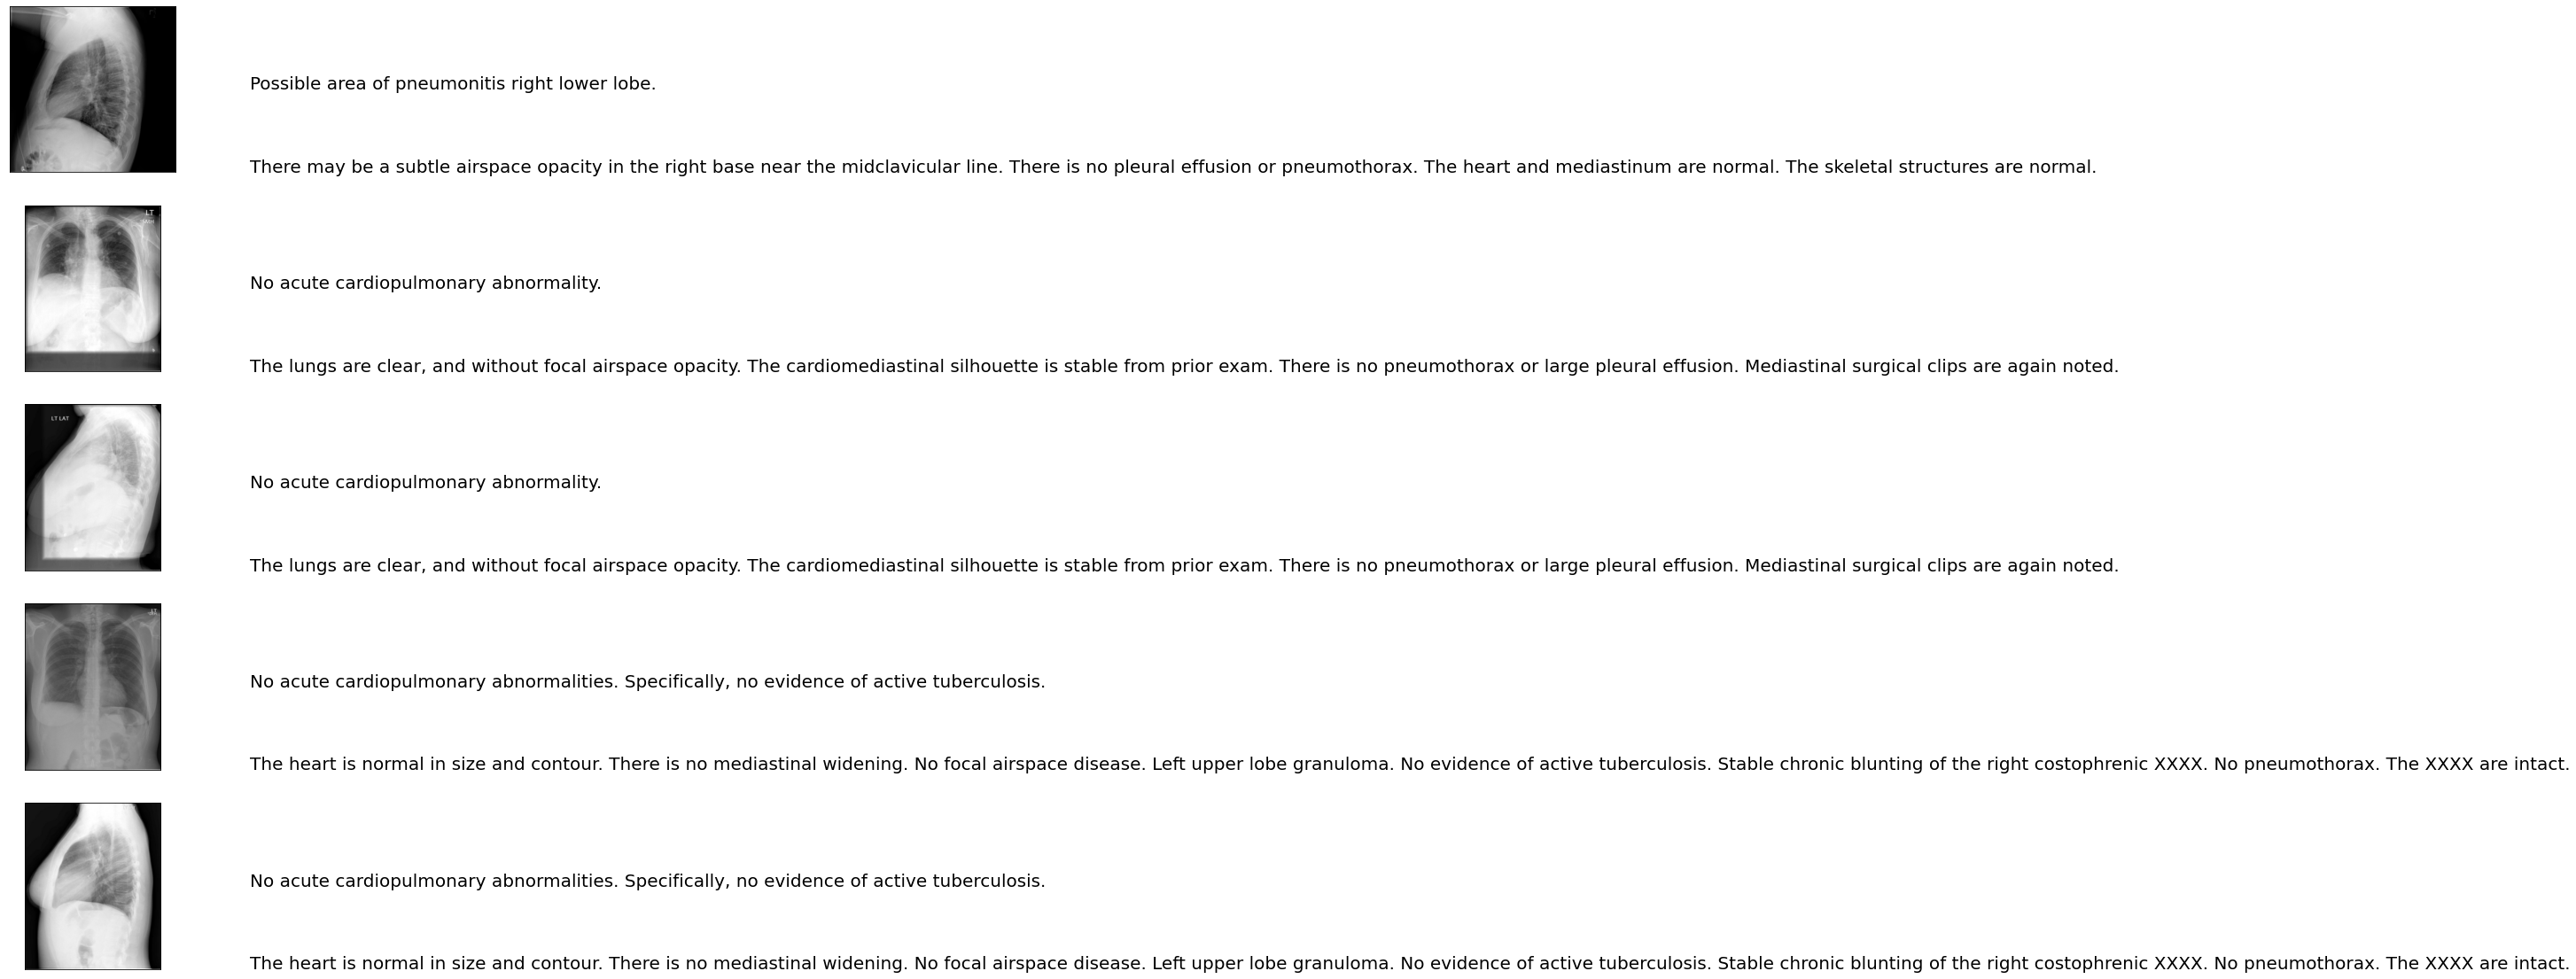

In [13]:
plot_image(data_frame, 5, 'REPORTS')

**check the height and weight of image because each image have different size.**

In [13]:
#Here we load the widths and heights of each image.
height= [] #Here we get the height of image. 
widhts= [] #Here we get the widths of image.
for k in np.unique(data_frame['Path'].values): #Here we get the values of chest x-ray images.
  image= cv2.imread(k) #read the images. 
  height.append(image.shape[0]) #Here we get the height of image.
  widhts.append(image.shape[1]) #Here we get the widths of image.

**Plot the figure of heights and weights of chest x-ray images.**

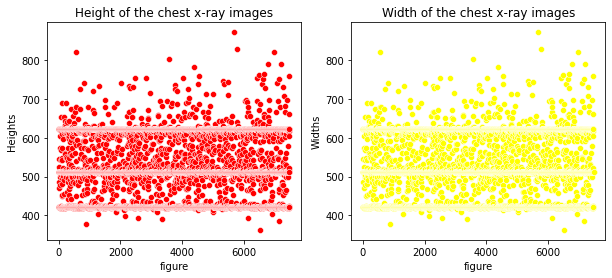

In [ ]:
plt.figure(figsize=(10,4))# here we plot the figure.
plt.subplot(121)# then initialize the first plot
plt.title('Height of the chest x-ray images')# title
plt.ylabel('Heights')# y axis label
plt.xlabel('figure')# x axis label
sns.scatterplot(range(len(height)), height, color= 'red')# seaborn scatter plot for height.
plt.subplot(122)# then initialize the second plot. 
plt.title('Width of the chest x-ray images')# title
plt.ylabel('Widths')# y axis label
plt.xlabel('figure')# x axis label
sns.scatterplot(range(len(widhts)), height, color= 'yellow')# seaborn scatter plot for widths.

**Observation:**

1. The data points in heights and widths shows us that the chest x-ray images have different heights and widths.  



**Check the shape of the dataframe**

In [43]:
print('The shape of data after removing the null values:', data_frame.shape)# here we print the shape of the dataframe after removing all null values.

The shape of data after removing the null values: (3851, 4)


**Here we plot the images and then check the findings and impressions for these corresponding images.**

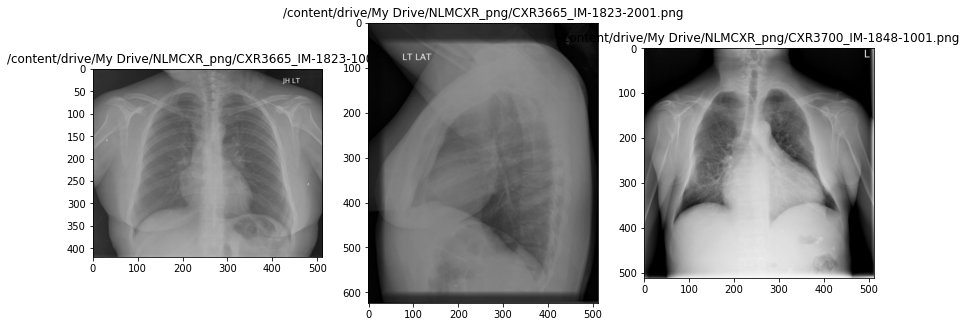

In [14]:
plt.figure(figsize=(14,7))# here we plot the figure taking 14 and 7 as figure size
plt.subplot(131)# first subplot
img1 = cv2.imread(data_frame['Path'].values[6])# read the first image
plt.imshow(img1)# show the first image
plt.title(data_frame['Path'].values[6])# read the title of the image
plt.subplot(132)# second subplot.
img2 = cv2.imread(data_frame['Path'].values[7])# read the second image of the plot.
plt.title(data_frame['Path'].values[7])# title of second image of the plot
plt.imshow(img2)# show the second image.
plt.subplot(133)# Third subplot
img3 = cv2.imread(data_frame['Path'].values[8])# read the third image of the plot.
plt.title(data_frame['Path'].values[8])# read the title of third image
plt.imshow(img3)# show the third image.

In [18]:
data_frame['findings'].values[6]# Finding for the first image.

'Heart size within normal limits. Negative for focal pulmonary consolidation, pleural effusion, or pneumothorax. No upper lobe airspace disease or cavitary lesions identified.'

In [19]:
data_frame['impression'].values[6]

'1. No acute abnormality. 2. No evidence of pulmonary tuberculosis.'

In [20]:
data_frame['findings'].values[7]# Finding for the second image.

'Heart size within normal limits. Negative for focal pulmonary consolidation, pleural effusion, or pneumothorax. No upper lobe airspace disease or cavitary lesions identified.'

In [21]:
data_frame['impression'].values[7]# Finding for the third image.

'1. No acute abnormality. 2. No evidence of pulmonary tuberculosis.'

In [22]:
data_frame['findings'].values[8]# Finding for the second image.

'Cardiomegaly is present. This is unchanged. There is mild prominence of the pulmonary vascularity which is unchanged. No XXXX focal airspace disease is seen. No pleural effusion or pneumothorax is identified.'

In [23]:
data_frame['impression'].values[8]# Finding for the third image.

'1. Cardiomegaly with mild vascular prominence. No change.'

**Observation:**

1. Here we found out that above two images finding is same except for the third one. It means this tells us that above two images are same but the scanned type of images are different and third image is totally different from the above two.

2. Similarly impression from the above two is same and the third one is different.



**Note:** As far i observed path value of all the images have same name for all the files except the last four digits. So, we can consider them as person ID for that chest X-ray image which seems to be unique for all the images.

**Now we try to create two dictionaries which have the keys as the person id and the number of images and findings and impressions for the person.**

In [24]:
IMAGES={}# create a dictionary of named image.
FINDINGS={}#create a dictionary of named findings.
IMPRESSION={}# create a dictionary of named Impression.

for image, fin, imp in data_frame.values: # here we have the image, finding ,and impression for each value in data_frame.
  k=image.split('-')# split the image values with the _.
  k.pop(len(k)-1)# take the len of image and subtract it with one and pop that value.
  k= '-'.join(i for i in k)
  if k not in IMAGES.keys(): # here if images is not in keys of images.
    IMAGES[k]=1 # them put the value for that image is 1
    FINDINGS[k]=fin # and put the corresponding finding to their corresponding person id.
    IMPRESSION[k]= imp # here also put the impression.
  else:
    IMAGES[k] +=1# otherwise  make it +1
    FINDINGS[k] = fin# fill the findings
    IMPRESSION[k] = imp  # fill the impreesion

In [25]:
IMAGES['/content/drive/My Drive/NLMCXR_png/CXR911_IM-2417']# check the person id.

2

In [26]:
FINDINGS['/content/drive/My Drive/NLMCXR_png/CXR911_IM-2417']# check the findings corresponding to their person id 2.

'Heart size within normal limits and cardiomediastinal contours are normal. Lungs are clear bilaterally. No focal consolidations. No pleural effusions or pneumothorax. Bony structures and soft tissues are unremarkable.'

In [27]:
IMPRESSION['/content/drive/My Drive/NLMCXR_png/CXR911_IM-2417']

'No active tuberculosis.'

In [28]:
print('Here total number of unique_IDS are:', len(IMAGES.keys()))# check unique person id.

Here total number of unique_IDS are: 3867


**Note:** Here one information is realized that there are 3344 unique images which are of different peoples out of 7470 images. 

**Let's check with the help of plot how many unique person ID has the multiple images on the same id.**

Text(0.5, 0, 'NUMBER OF UNIQUE PERSON IN THE DATA')

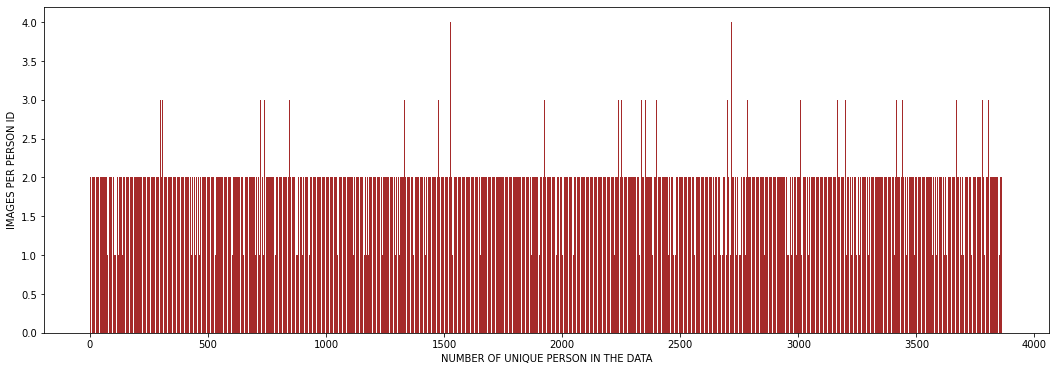

In [29]:
plt.figure(figsize=(18,6))# intialize the figure size.
plt.bar(range(len(IMAGES.keys())), IMAGES.values(),color='brown')# here we plot the bar graph with the images keys.
plt.ylabel('IMAGES PER PERSON ID')
plt.xlabel('NUMBER OF UNIQUE PERSON IN THE DATA')

**Observation:**


1. From the above plot we can observe that there are less no of IDS which have four images corresponding to the ids.

2. Maximum ids have the two chest x-ray images corresponding to the person ids.



**Let's check the count of the numbers of ids which have multiple chest x-ray images on them.**

In [30]:
One_images_corr_ids= 0 # intialize the one images per person id
Two_images_corr_ids= 0  # intialize the two images per person id
Three_images_corr_ids= 0 # intialize the three images per person id
Four_images_corr_ids= 0  # intialize the four images per person id

for count in IMAGES.values(): # for each values in IMAGES
  if count == 1:  # first check the count of the value =1
    One_images_corr_ids+=1# increase the count for the only one person_id.
  elif count == 2:# first check the count of the value =2
    Two_images_corr_ids+=1# increase the count for the only two person_id.
  elif count == 3:# first check the count of the value =3
    Three_images_corr_ids+=1# increase the count for the only three person_id.
  elif count == 4:# first check the count of the value =4
    Four_images_corr_ids+=1# increase the count for the only Four person_id.
  else:
    print('ERROR')  

In [31]:
print('count of those IDS which have only one image:',One_images_corr_ids)

count of those IDS which have only one image: 457


In [32]:
print('count of those IDS which have two image:',Two_images_corr_ids)

count of those IDS which have two image: 3227


In [33]:
print('count of those IDS which have three image:',Three_images_corr_ids)

count of those IDS which have three image: 173


In [34]:
print('count of those IDS which have fourth image:',Four_images_corr_ids)

count of those IDS which have fourth image: 10


**Observation:**

1. Count of the Ids which have the two images is 3227 which is maximum in comparison to 457 ids which have only one image and 173 ids have 3 multiple images and minimum four images corresponding to 10 person ids.
2. With the help of this analysis we can conclude that there are multiple images corresponding to a single person. These are different chest scans at different views. 



**As we able to see that there are 3 and 4 images exist corresponding one xml files somewhere its create a problem for getting only frontal images as only limiting the images to two images in our data so we try to extract only frontal and lateral image if we have more than 2 images for a corresponding xml files.**

**we use this data to map that frontal and lateral image with our data frame images**

In [44]:
# https://www.kaggle.com/raddar/chest-xrays-indiana-university
data_projecttions = pd.read_csv("/content/indiana_projections.csv")

**for extracting frontal and lateral image**

In [51]:
def find_Fr_la(li):
    list_of_images = [] # here we get the list of images
    image_last = "" # last image 
    for i in li:# for each image in list of image
        projection = data_projecttions[data_projecttions['filename'].str.contains(re.search(r"\d.*\_IM-\d.*\.", i).group())]['projection'].values# get the corresponding projection values to the dataframe.
        if "Lateral" == projection:# check projection is lateral
            image_last = i# make it last image
        else:
            list_of_images.append(i)# otherwise make them frontal images
    return list_of_images, image_last

**data_frame having frontal and lateral image corresponding to findings and impression.**

In [52]:
columns = ["image_1", "image_2", "impression","findings"]
df = pd.DataFrame(columns = columns)
no_lateral = 0
for item in tqdm(data_frame.iterrows()):
    lnegth_of_image = item[1]['Path'].split(',')# getting all the images corresponding to each path
    if len(lnegth_of_image) > 2:# check images are more than two in each xml file
        list_of_images, image_last = find_Fr_la(lnegth_of_image)# get the frontal and lateral image
        if image_last == "":# check if last image is none.
            no_lateral +=1# then increase the no lateral by one
            list_of_images, image_last = list_of_images[:-1], list_of_images[-1]# and get the last image an list of images
        for i in list_of_images:# for each image in list of images
            image_1 = i# get the frontal image as first image
            image_2 = image_last# and get the lateral image as last image
            df = df.append(pd.Series([image_1, image_2, item[1]['impression'],item[1]['findings']], index = columns), ignore_index = True)# make the dataframe.
    elif len(l) == 2:# check for only two images
        image_1 = lnegth_of_image[0] # get the first image
        image_2 = lnegth_of_image[1]# get the second image
        df = df.append(pd.Series([image_1, image_2, item[1]['impression'],item[1]['findings']], index = columns), ignore_index = True)# cmake the dataframe
    elif len(l) == 1:# check if we have only one image, here we copy the only one image second time.
        df = df.append(pd.Series([lnegth_of_image[0],lnegth_of_image[0], item[1]['impression'],item[1]['findings']], index = columns), ignore_index = True)# 
print("Total Report without Lateral images {}".format(no_lateral))

3851it [00:12, 300.83it/s]

Total Report without Lateral images 1


In [53]:
df

,image_1,image_2,impression,findings
0,CXR3679_IM-1831-1001.png,CXR3679_IM-1831-2001.png,Normal chest exam.,Normal heart. Clear lungs. No pneumothorax. No...
1,CXR3681_IM-1833-0001-0001.png,CXR3681_IM-1833-0001-0002.png,No acute abnormality identified.,There are lower lung volumes. There is central...
2,CXR368_IM-1832-2001.png,CXR368_IM-1832-1001.png,No acute cardiopulmonary findings.,Cardiomediastinal silhouette and pulmonary vas...
3,CXR3665_IM-1823-1001.png,CXR3665_IM-1823-2001.png,1. No acute abnormality. 2. No evidence of pul...,Heart size within normal limits. Negative for ...
4,CXR3697_IM-1846-2001.png,CXR3697_IM-1846-1001.png,1. No acute cardiopulmonary findings. 2. Exten...,The cardiomediastinal silhouette is stable in ...
...,...,...,...,...
3527,CXR1842_IM-0545-1002.png,CXR1842_IM-0545-1001.png,Heart size normal. Lungs clear. Stable 5 mm ca...,None
3528,CXR187_IM-0563-1001.png,CXR187_IM-0563-2001.png,Unchanged exam without acute abnormality.,Normal heart size. Stable tortuous aorta. No p...
3529,CXR185_IM-0551-1001.png,CXR185_IM-0551-2001.png,No acute disease.,The heart is normal in size. The mediastinum i...
3530,CXR1851_IM-0553-2001.png,CXR1851_IM-0553-1001.png,No acute cardiopulmonary findings. .,Heart size is normal. No focal airspace consol...


**Preprocessing of findings and impression**

**1. Decontractions of words like won't to will not.**

In [54]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)

    
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

**Lowercase all the letters**

In [55]:
def lowercase(text):
  text= text.lower()
  return text

**Remove the punctuations from the text**

In [56]:
def punctuations_remove(text):
  punct='''!()-[]{};:'"\,<>/?@#$%^&*~'''
  for char in text:
    if char in punct:
      text= text.replace(char,"")
    text= " ".join(k for k in text.split())
  return text  

**Remove the numbers from the text**

In [57]:
def numbers(text):
  tem= re.sub(r'x*','',text)
  text= re.sub(r'\d','',tem)
  return text 

**Remove the words who has length then two except no and ct.**

In [58]:
def filters(text):
  tem= text.split()
  tem2= []
  for word in tem:
    if len(word) <=2 and word !='no' and word!='ct':
      continue
    else:
      tem2.append(word)
    text=' '.join(k for k in tem2)
  return text    

**Remove the fullstops**

In [59]:
def fullstops(text):
  text=re.sub(r'\.\.+','.',text)
  return text 

In [60]:
def stops(text):
    text= re.sub('\.',' .', text)
    return text

**Remove the spaces**

In [61]:
def spaces(text):
  text= ' '.join(k for k in text.split())
  return text  

In [62]:
def words(text):
  temp=[]
  words= text.split()
  for i in words:
    if i.startswith('.') == False:
      temp.append(i)
    else:
      k = i.replace('.','. ')
      temp.append(k)
    text= ' '.join(k for k in temp)
  return text

**Remove the apostrophe from the text.**

In [63]:
def remaining_apostrophe(text):
  text= re.sub("'",'',text)
  return text

In [64]:
import re
def preprocess(text):
  new_text = re.sub('XXXX','',str(text))#substituting XXXX string which occurs n most of the impressions with space as it has no semantic meaning
  new_text=re.sub(r'[^A-Za-z]+',' ',new_text)#replacing anything other than words wtih space
  new_text = decontracted(new_text)#decontracting the words
  new_text=   lowercase(new_text)
  new_text= punctuations_remove(new_text)
  new_text= numbers(new_text)
  new_text= filters(new_text)
  new_text= fullstops(new_text)
  new_text= stops(new_text)
  new_text= spaces(new_text)
  new_text= words(new_text)
  new_text= remaining_apostrophe(new_text)

  # text = re.sub('\\r', ' ',text)#replacing new line with space
  # text = re.sub('\\n', ' ',text)#replacing tab with single space
  
  return new_text

**Text Preprocessing**

**Preprocess the impression data**

In [65]:
df['impression']=df['impression'].map(preprocess)

**Preporcess the findings data**

In [66]:
df['findings']=df['findings'].map(preprocess)

In [67]:
df

,image_1,image_2,impression,findings
0,CXR3679_IM-1831-1001.png,CXR3679_IM-1831-2001.png,normal chest eam,normal heart clear lungs no pneumothora no ple...
1,CXR3681_IM-1833-0001-0001.png,CXR3681_IM-1833-0001-0002.png,no acute abnormality identified,there are lower lung volumes there central bro...
2,CXR368_IM-1832-2001.png,CXR368_IM-1832-1001.png,no acute cardiopulmonary findings,cardiomediastinal silhouette and pulmonary vas...
3,CXR3665_IM-1823-1001.png,CXR3665_IM-1823-2001.png,no acute abnormality no evidence pulmonary tub...,heart size within normal limits negative for f...
4,CXR3697_IM-1846-2001.png,CXR3697_IM-1846-1001.png,no acute cardiopulmonary findings etensive fib...,the cardiomediastinal silhouette stable appear...
...,...,...,...,...
3527,CXR1842_IM-0545-1002.png,CXR1842_IM-0545-1001.png,heart size normal lungs clear stable calcified...,none
3528,CXR187_IM-0563-1001.png,CXR187_IM-0563-2001.png,unchanged eam without acute abnormality,normal heart size stable tortuous aorta no pne...
3529,CXR185_IM-0551-1001.png,CXR185_IM-0551-2001.png,no acute disease,the heart normal size the mediastinum stable l...
3530,CXR1851_IM-0553-2001.png,CXR1851_IM-0553-1001.png,no acute cardiopulmonary findings,heart size normal no focal airspace consolidat...


**Let's get the number of words in each findings**

In [68]:
length_word_findings=[len(k.split()) for k in df['findings'].values]

**Let's get the number of words in each impression**

In [69]:
length_word_impression=[len(k.split()) for k in df['impression'].values]

In [70]:
print('maximum length of the sentence in findings:',max(length_word_findings))
print('maximum length of the sentence in impression:',max(length_word_impression))

maximum length of the sentence in findings: 122
maximum length of the sentence in impression: 104


In [71]:
range((df.shape[0]),1)

range(3532, 1)

**Plot the number of words in a findings**

Text(0, 0.5, 'Number of words')

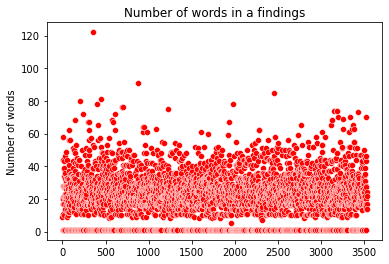

In [72]:
plt.title('Number of words in a findings')
sns.scatterplot(range(df.shape[0]),length_word_findings, color='red')
plt.ylabel('Number of words')

**Observation:** 
1. Above figure shows us that most of the word count is below 100.
2. Most of the points are dense lie in the range below 50 . It means most of the length of word count is below 50.


**Plot the number of words in each impression**

Text(0, 0.5, 'Number of words')

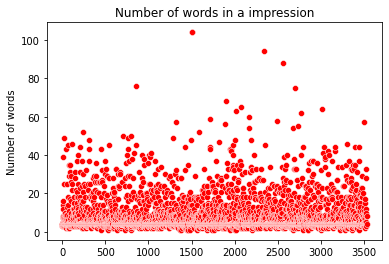

In [73]:
plt.title('Number of words in a impression')
sns.scatterplot(range(df.shape[0]),length_word_impression, color='red')
plt.ylabel('Number of words')

**Observation:**

1.   Above figure shows us that most of the word count is below 20.
2. Most of the points are dense lie in the range below 10 . It means most of the length of word count is below 10.




**for findings**

In [74]:
length_findings= []
for i in df['findings'].values:
  length_findings.extend(i.split())

**for impression**

In [75]:
length_impression= []
for i in df['impression'].values:
  length_impression.extend(i.split())

In [76]:
counter_findings= Counter(length_findings)

In [77]:
counter_impression= Counter(length_impression)

In [78]:
words_finding= []
count_finding= []
for key,value in counter_findings.items():
  words_finding.append(key)
  count_finding.append(value)
count_words_findings = list(zip(count_finding,words_finding))  

In [79]:
words_impression= []
count_impression= []
for key,value in counter_impression.items():
  words_impression.append(key)
  count_impression.append(value)
count_words_impression = list(zip(count_finding,words_finding))  

In [80]:
top_words_50_findings= sorted(count_words_findings)[::-1][:50]
top_words_50_impression= sorted(count_words_impression)[::-1][:50]
low_words_50_findings= sorted(count_words_findings)[:50]
low_words_50_impression= sorted(count_words_impression)[:50]


([<matplotlib.axis.XTick at 0x7fe2f15d47b8>,
 [Text(0, 0, 'the'),
  Text(0, 0, 'no'),
  Text(0, 0, 'are'),
  Text(0, 0, 'normal'),
  Text(0, 0, 'and'),
  Text(0, 0, 'pleural'),
  Text(0, 0, 'pneumothora'),
  Text(0, 0, 'there'),
  Text(0, 0, 'effusion'),
  Text(0, 0, 'heart'),
  Text(0, 0, 'lungs'),
  Text(0, 0, 'size'),
  Text(0, 0, 'focal'),
  Text(0, 0, 'within'),
  Text(0, 0, 'clear'),
  Text(0, 0, 'limits'),
  Text(0, 0, 'pulmonary'),
  Text(0, 0, 'consolidation'),
  Text(0, 0, 'silhouette'),
  Text(0, 0, 'right'),
  Text(0, 0, 'mediastinal'),
  Text(0, 0, 'cardiomediastinal'),
  Text(0, 0, 'airspace'),
  Text(0, 0, 'left'),
  Text(0, 0, 'acute'),
  Text(0, 0, 'lung'),
  Text(0, 0, 'spine'),
  Text(0, 0, 'with'),
  Text(0, 0, 'disease'),
  Text(0, 0, 'unremarkable'),
  Text(0, 0, 'structures'),
  Text(0, 0, 'changes'),
  Text(0, 0, 'mediastinum'),
  Text(0, 0, 'stable'),
  Text(0, 0, 'contours'),
  Text(0, 0, 'bony'),
  Text(0, 0, 'thoracic'),
  Text(0, 0, 'none'),
  Text(0, 0, 'c

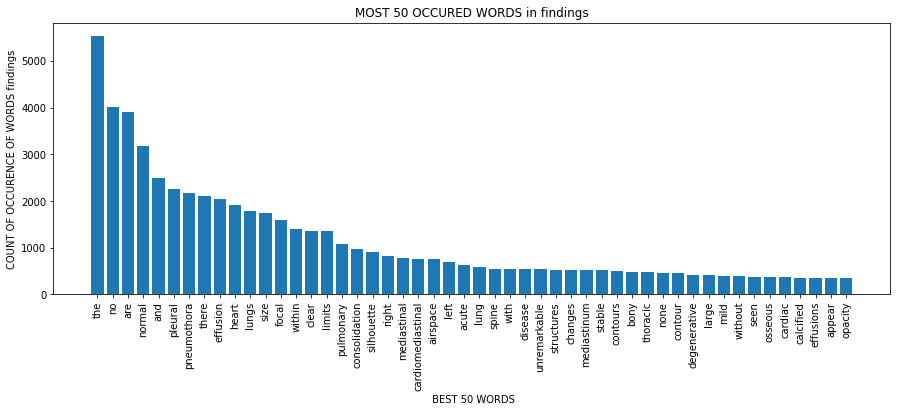

In [81]:
plt.figure(figsize=(15,5))
plt.bar(range(50),[i for i,w in top_words_50_findings])
plt.title('MOST 50 OCCURED WORDS in findings')
plt.xlabel(' BEST 50 WORDS')
plt.ylabel('COUNT OF OCCURENCE OF WORDS findings')
plt.xticks(ticks=range(50), labels=[word for i,word in top_words_50_findings],rotation=90)

([<matplotlib.axis.XTick at 0x7fe2f153b940>,
 [Text(0, 0, 'the'),
  Text(0, 0, 'no'),
  Text(0, 0, 'are'),
  Text(0, 0, 'normal'),
  Text(0, 0, 'and'),
  Text(0, 0, 'pleural'),
  Text(0, 0, 'pneumothora'),
  Text(0, 0, 'there'),
  Text(0, 0, 'effusion'),
  Text(0, 0, 'heart'),
  Text(0, 0, 'lungs'),
  Text(0, 0, 'size'),
  Text(0, 0, 'focal'),
  Text(0, 0, 'within'),
  Text(0, 0, 'clear'),
  Text(0, 0, 'limits'),
  Text(0, 0, 'pulmonary'),
  Text(0, 0, 'consolidation'),
  Text(0, 0, 'silhouette'),
  Text(0, 0, 'right'),
  Text(0, 0, 'mediastinal'),
  Text(0, 0, 'cardiomediastinal'),
  Text(0, 0, 'airspace'),
  Text(0, 0, 'left'),
  Text(0, 0, 'acute'),
  Text(0, 0, 'lung'),
  Text(0, 0, 'spine'),
  Text(0, 0, 'with'),
  Text(0, 0, 'disease'),
  Text(0, 0, 'unremarkable'),
  Text(0, 0, 'structures'),
  Text(0, 0, 'changes'),
  Text(0, 0, 'mediastinum'),
  Text(0, 0, 'stable'),
  Text(0, 0, 'contours'),
  Text(0, 0, 'bony'),
  Text(0, 0, 'thoracic'),
  Text(0, 0, 'none'),
  Text(0, 0, 'c

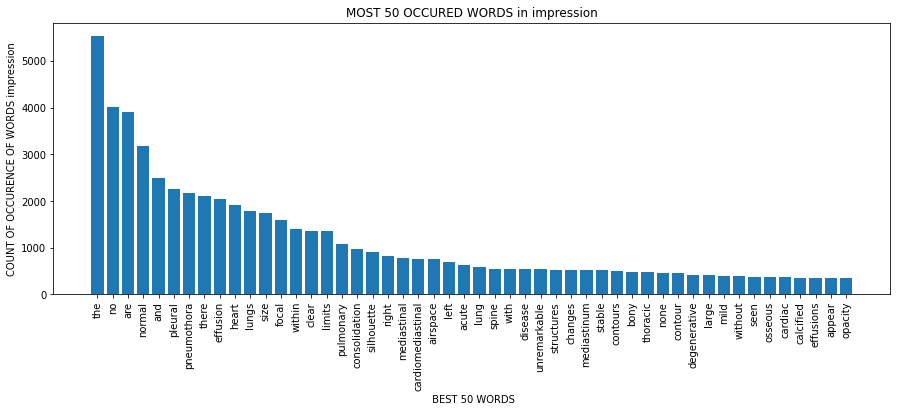

In [82]:
plt.figure(figsize=(15,5))
plt.bar(range(50),[i for i,w in top_words_50_impression])
plt.title('MOST 50 OCCURED WORDS in impression')
plt.xlabel(' BEST 50 WORDS')
plt.ylabel('COUNT OF OCCURENCE OF WORDS impression')
plt.xticks(ticks=range(50), labels=[word for i,word in top_words_50_impression],rotation=90)

([<matplotlib.axis.XTick at 0x7fe2f6acd8d0>,
 [Text(0, 0, 'abnormally'),
  Text(0, 0, 'about'),
  Text(0, 0, 'absence'),
  Text(0, 0, 'abut'),
  Text(0, 0, 'accentuates'),
  Text(0, 0, 'accessed'),
  Text(0, 0, 'account'),
  Text(0, 0, 'acuity'),
  Text(0, 0, 'additionally'),
  Text(0, 0, 'after'),
  Text(0, 0, 'aicd'),
  Text(0, 0, 'ailla'),
  Text(0, 0, 'all'),
  Text(0, 0, 'although'),
  Text(0, 0, 'angulate'),
  Text(0, 0, 'annular'),
  Text(0, 0, 'anterolateral'),
  Text(0, 0, 'aorticopulmonary'),
  Text(0, 0, 'aorto'),
  Text(0, 0, 'appearances'),
  Text(0, 0, 'appreciable'),
  Text(0, 0, 'appropriate'),
  Text(0, 0, 'arterial'),
  Text(0, 0, 'arthroplasty'),
  Text(0, 0, 'articular'),
  Text(0, 0, 'artifactually'),
  Text(0, 0, 'asbestos'),
  Text(0, 0, 'aside'),
  Text(0, 0, 'aspergilloma'),
  Text(0, 0, 'aspiration'),
  Text(0, 0, 'assessment'),
  Text(0, 0, 'attached'),
  Text(0, 0, 'atypical'),
  Text(0, 0, 'avn'),
  Text(0, 0, 'back'),
  Text(0, 0, 'bacterial'),
  Text(0, 0

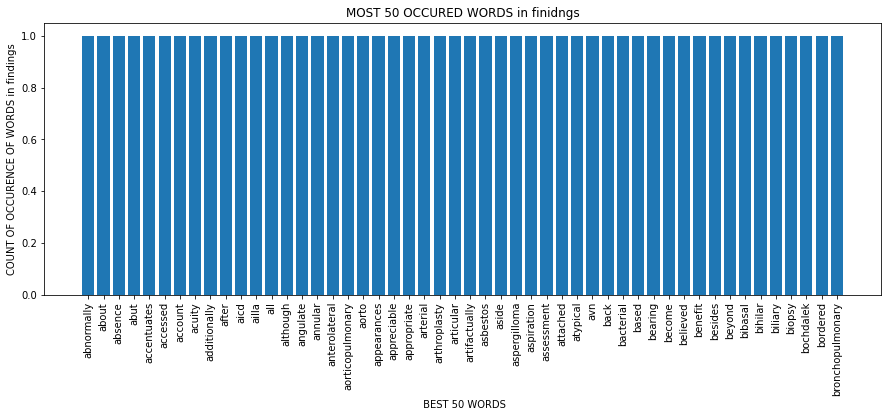

In [83]:
plt.figure(figsize=(15,5))
plt.bar(range(50),[i for i,w in low_words_50_findings])
plt.title('MOST 50 OCCURED WORDS in finidngs')
plt.xlabel(' BEST 50 WORDS')
plt.ylabel('COUNT OF OCCURENCE OF WORDS in findings')
plt.xticks(ticks=range(50), labels=[word for i,word in low_words_50_findings],rotation=90)

([<matplotlib.axis.XTick at 0x7fe2f12cec88>,
 [Text(0, 0, 'abnormally'),
  Text(0, 0, 'about'),
  Text(0, 0, 'absence'),
  Text(0, 0, 'abut'),
  Text(0, 0, 'accentuates'),
  Text(0, 0, 'accessed'),
  Text(0, 0, 'account'),
  Text(0, 0, 'acuity'),
  Text(0, 0, 'additionally'),
  Text(0, 0, 'after'),
  Text(0, 0, 'aicd'),
  Text(0, 0, 'ailla'),
  Text(0, 0, 'all'),
  Text(0, 0, 'although'),
  Text(0, 0, 'angulate'),
  Text(0, 0, 'annular'),
  Text(0, 0, 'anterolateral'),
  Text(0, 0, 'aorticopulmonary'),
  Text(0, 0, 'aorto'),
  Text(0, 0, 'appearances'),
  Text(0, 0, 'appreciable'),
  Text(0, 0, 'appropriate'),
  Text(0, 0, 'arterial'),
  Text(0, 0, 'arthroplasty'),
  Text(0, 0, 'articular'),
  Text(0, 0, 'artifactually'),
  Text(0, 0, 'asbestos'),
  Text(0, 0, 'aside'),
  Text(0, 0, 'aspergilloma'),
  Text(0, 0, 'aspiration'),
  Text(0, 0, 'assessment'),
  Text(0, 0, 'attached'),
  Text(0, 0, 'atypical'),
  Text(0, 0, 'avn'),
  Text(0, 0, 'back'),
  Text(0, 0, 'bacterial'),
  Text(0, 0

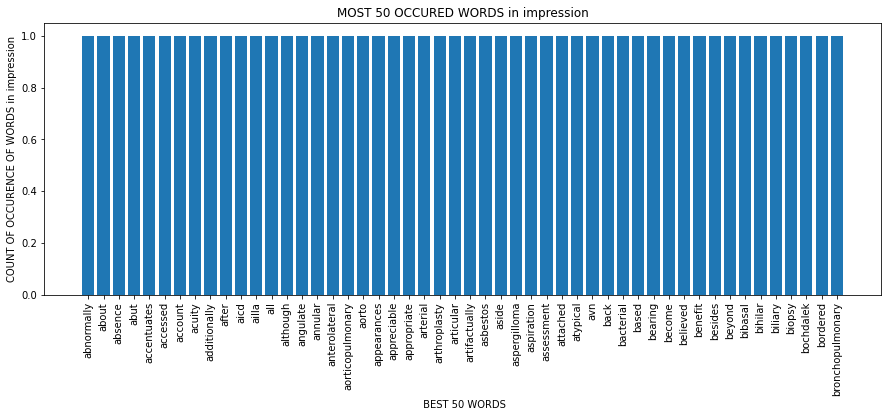

In [84]:
plt.figure(figsize=(15,5))
plt.bar(range(50),[i for i,w in low_words_50_impression])
plt.title('MOST 50 OCCURED WORDS in impression')
plt.xlabel(' BEST 50 WORDS')
plt.ylabel('COUNT OF OCCURENCE OF WORDS in impression')
plt.xticks(ticks=range(50), labels=[word for i,word in low_words_50_impression],rotation=90)

In [85]:
stopwords1 = set(STOPWORDS)#setting stopwords

Word Cloud for findings 


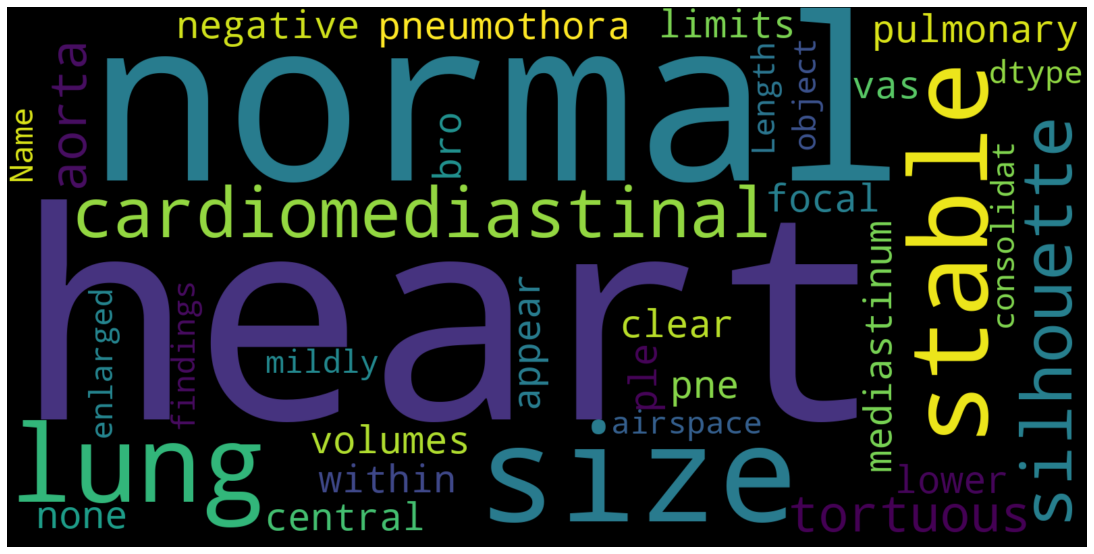

In [86]:
# generating word cloud of most occuring words ignoring stop words 
wc = WordCloud(background_color="black", max_words=len(df),width=1600,
                          height=800, stopwords=stopwords1)
wc.generate(str(df["findings"]))
print("Word Cloud for findings ")
fig = plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Word Cloud for IMPRESSION 


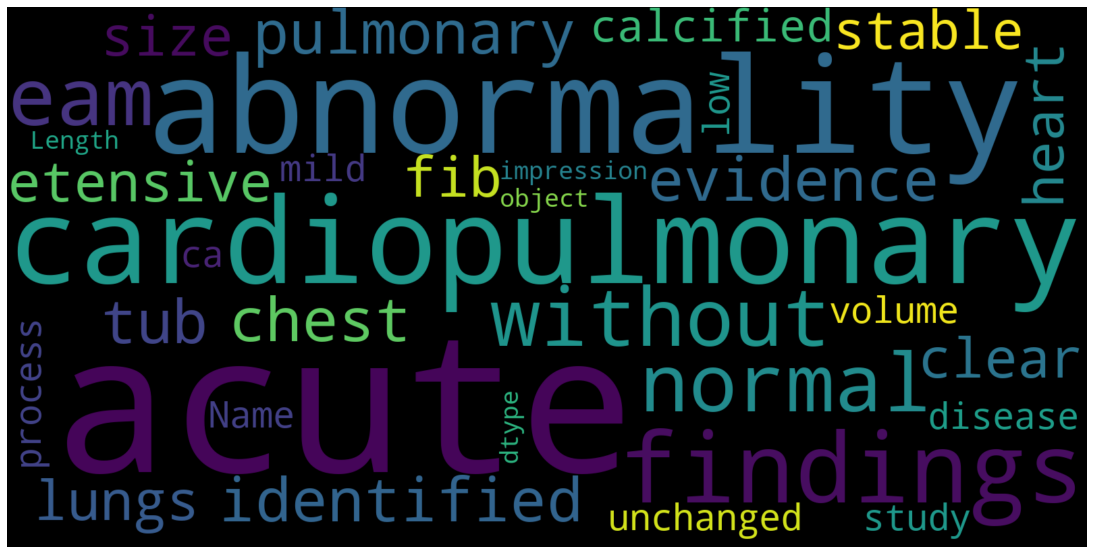

In [87]:
# generating word cloud of most occuring words ignoring stop words 
wc = WordCloud(background_color="black", max_words=len(df),width=1600,
                          height=800, stopwords=stopwords1)
wc.generate(str(df["impression"]))
print("Word Cloud for IMPRESSION ")
fig = plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [88]:
def remodelling_of_data(x):
  return 'start'+ ' ' + x + ' ' + 'end'

In [89]:
df['impression']=df['impression'].apply(lambda x : remodelling_of_data(x))

In [90]:
df['findings']=df['findings'].apply(lambda x : remodelling_of_data(x))


In [91]:
df

,image_1,image_2,impression,findings
0,CXR3679_IM-1831-1001.png,CXR3679_IM-1831-2001.png,start normal chest eam end,start normal heart clear lungs no pneumothora ...
1,CXR3681_IM-1833-0001-0001.png,CXR3681_IM-1833-0001-0002.png,start no acute abnormality identified end,start there are lower lung volumes there centr...
2,CXR368_IM-1832-2001.png,CXR368_IM-1832-1001.png,start no acute cardiopulmonary findings end,start cardiomediastinal silhouette and pulmona...
3,CXR3665_IM-1823-1001.png,CXR3665_IM-1823-2001.png,start no acute abnormality no evidence pulmona...,start heart size within normal limits negative...
4,CXR3697_IM-1846-2001.png,CXR3697_IM-1846-1001.png,start no acute cardiopulmonary findings etensi...,start the cardiomediastinal silhouette stable ...
...,...,...,...,...
3527,CXR1842_IM-0545-1002.png,CXR1842_IM-0545-1001.png,start heart size normal lungs clear stable cal...,start none end
3528,CXR187_IM-0563-1001.png,CXR187_IM-0563-2001.png,start unchanged eam without acute abnormality end,start normal heart size stable tortuous aorta ...
3529,CXR185_IM-0551-1001.png,CXR185_IM-0551-2001.png,start no acute disease end,start the heart normal size the mediastinum st...
3530,CXR1851_IM-0553-2001.png,CXR1851_IM-0553-1001.png,start no acute cardiopulmonary findings end,start heart size normal no focal airspace cons...


In [99]:
df.to_csv('preprocessed_data_with_only_frontal_lateral.csv',index=False)
